In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import warnings

In [177]:
warnings.filterwarnings("ignore")

In [178]:
# Load dataset
df = pd.read_csv("tea_forex.csv", parse_dates=["Year-Month"], index_col="Year-Month")

In [179]:
df.head()

High_Grown_Production_(Kg)  Mid_Grown_Production_(Kg)  \
Year-Month                                                          
2012-01-01                  5361185.05                 3652353.15   
2012-02-01                  5538399.31                 3955745.75   
2012-03-01                  6385525.09                 4625138.90   
2012-04-01                  7323011.00                 5748401.20   
2012-05-01                  8726319.70                 5898297.10   

            Low_Grown_Production_(Kg)  National_Production_(Kg)  \
Year-Month                                                        
2012-01-01                14348315.90               23361854.10   
2012-02-01                13133213.00               22627358.06   
2012-03-01                17929328.00               28939991.99   
2012-04-01                16982493.50               30053905.70   
2012-05-01                18086627.25               32711244.05   

            FEE_(Million_USD)  
Year-Month                     
2012-01-01              95.32  
2012-02-01             100.17  
2012-03-01             130.31  
2012-04-01             110.41  
2012-05-01             149.19

In [180]:
# Select only the column needed for forecasting
fee_data = df[["FEE_(Million_USD)"]].copy()  # Preserve DataFrame structure

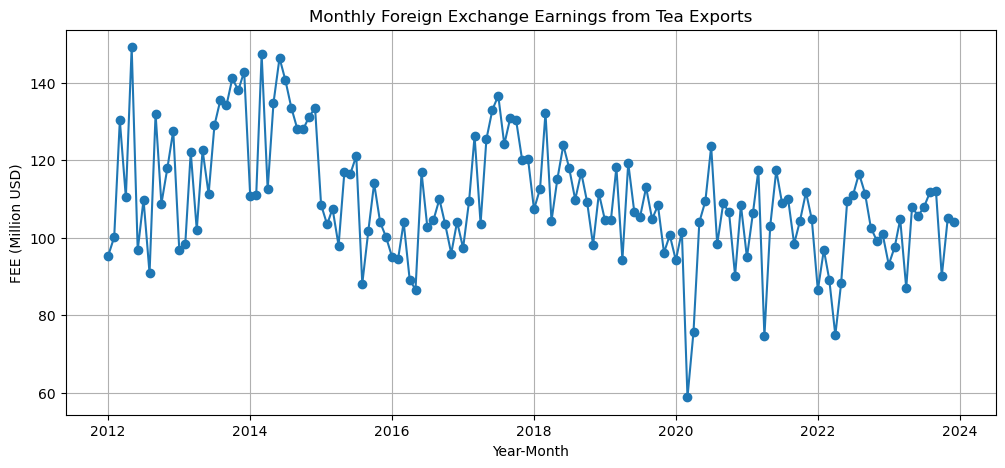

In [181]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(fee_data, marker='o', linestyle='-')
plt.title("Monthly Foreign Exchange Earnings from Tea Exports")
plt.xlabel("Year-Month")
plt.ylabel("FEE (Million USD)")
plt.grid()
plt.show()

In [182]:
# 1. Augmented Dickey-Fuller (ADF) Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("Series is stationary.")
    else:
        print("Series is NOT stationary.")

In [183]:
print("ADF Test Before Differencing:")
adf_test(fee_data["FEE_(Million_USD)"])

ADF Test Before Differencing:
ADF Statistic: -2.132880924046966
p-value: 0.23150015682751962
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Series is NOT stationary.


In [184]:
from scipy.stats import skew

print("Skewness before Box-Cox:", skew(fee_data["FEE_(Million_USD)"]))
# If skewness is between -1 and 1, transformation isnâ€™t needed.

Skewness before Box-Cox: 0.14176181466959217


In [185]:
# 2. Apply Box-Cox transformation
fee_data["FEE_BoxCox"], lambda_value = boxcox(fee_data["FEE_(Million_USD)"])
print("Optimal Box-Cox Lambda:", lambda_value)

Optimal Box-Cox Lambda: 0.7925673191304697


In [186]:
# 3. First Differencing
fee_data["FEE_BoxCox_Diff"] = fee_data["FEE_(Million_USD)"].diff().dropna()

In [187]:
print("ADF Test After First Differencing:")
adf_test(fee_data["FEE_BoxCox_Diff"].dropna())

ADF Test After First Differencing:
ADF Statistic: -3.3914369173972982
p-value: 0.011254273368081267
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Series is stationary.


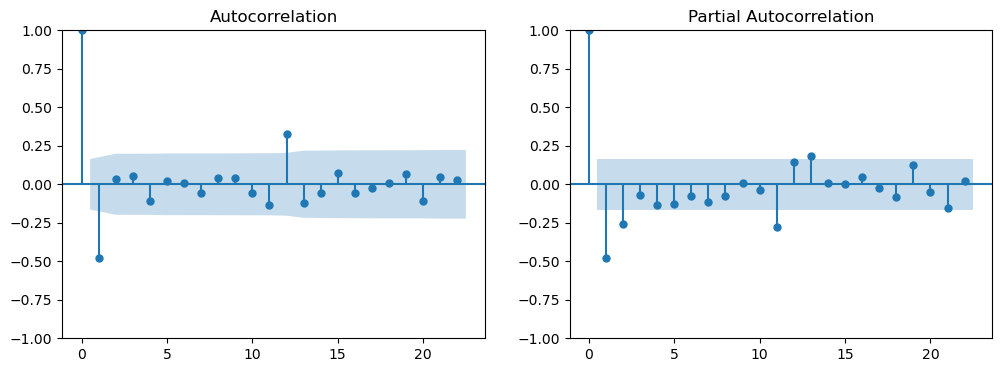

In [188]:
# 4. ACF & PACF Plots to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(fee_data["FEE_BoxCox_Diff"].dropna(), ax=axes[0])
plot_pacf(fee_data["FEE_BoxCox_Diff"].dropna(), ax=axes[1])
plt.show()

In [189]:
# 5. Split data into train and test sets
train_size = int(len(fee_data) * 0.8)
train, test = fee_data["FEE_(Million_USD)"][:train_size], fee_data["FEE_(Million_USD)"][train_size:]

In [190]:
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=937.175, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=976.716, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=945.529, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=931.255, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=974.722, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=933.226, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=933.230, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=935.195, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=929.262, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=931.232, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=931.236, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=943.549, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=933.200, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.786 seconds
                               SARI

In [191]:
# 6. Train ARIMA Model
p, d, q = 11, 1, 12  # Adjust based on ACF & PACF
model = ARIMA(train, order=(p, d, q))
arima_model = model.fit()

In [192]:
# Print Model Summary
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:      FEE_(Million_USD)   No. Observations:                  115
Model:               ARIMA(11, 1, 12)   Log Likelihood                -445.238
Date:                Sun, 16 Mar 2025   AIC                            938.477
Time:                        00:52:49   BIC                           1004.145
Sample:                    01-01-2012   HQIC                           965.128
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1152      0.177     -6.308      0.000      -1.462      -0.769
ar.L2         -0.8734      0.226     -3.867      0.000      -1.316      -0.431
ar.L3         -0.4856      0.245     -1.984      0.0

In [193]:
# 7. Forecast future values
forecast = arima_model.forecast(steps=len(test))

In [194]:
# Convert predictions back using inverse Box-Cox transformation
# forecast_inverted = inv_boxcox(forecast, lambda_value)

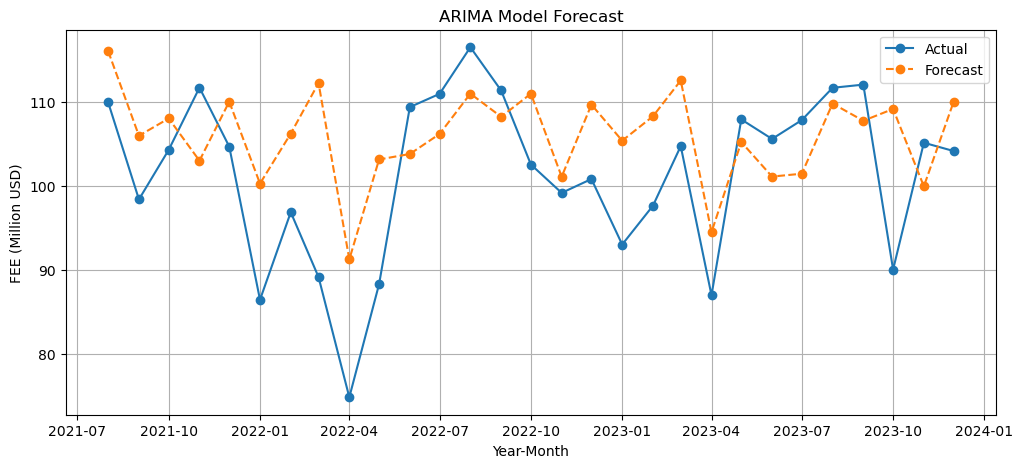

In [195]:
# 8. Plot Actual vs. Forecast
plt.figure(figsize=(12, 5))
plt.plot(fee_data.index[train_size:], test, label="Actual", marker="o")
plt.plot(fee_data.index[train_size:], forecast, label="Forecast", marker="o", linestyle="dashed")
plt.title("ARIMA Model Forecast")
plt.xlabel("Year-Month")
plt.ylabel("FEE (Million USD)")
plt.legend()
plt.grid()
plt.show()

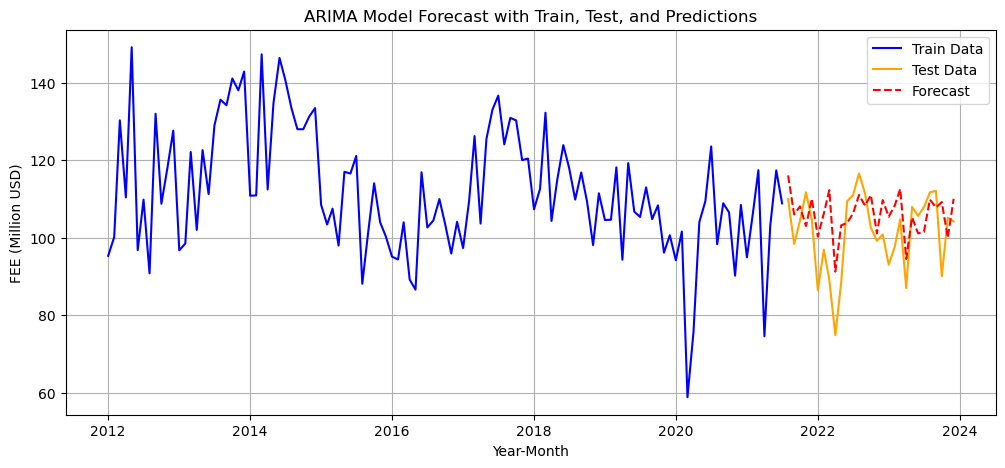

In [196]:
# Plot Actual vs. Forecast, including train and test data
plt.figure(figsize=(12, 5))
plt.plot(fee_data.index[:train_size], train, label="Train Data", color="blue")
plt.plot(fee_data.index[train_size:], test, label="Test Data", color="orange")
plt.plot(fee_data.index[train_size:], forecast, label="Forecast", color="red", linestyle="dashed")
plt.title("ARIMA Model Forecast with Train, Test, and Predictions")
plt.xlabel("Year-Month")
plt.ylabel("FEE (Million USD)")
plt.legend()
plt.grid()
plt.show()

In [201]:
# Model Evaluation
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

In [204]:
print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.4f}")
print(f"Akaike Information Criterion (AIC): {arima_model.aic:.4f}")


Model Evaluation Metrics:
Mean Squared Error (MSE): 92.1687
Root Mean Squared Error (RMSE): 9.6005
Mean Absolute Percentage Error (MAPE): 8.5038
Akaike Information Criterion (AIC): 938.4767


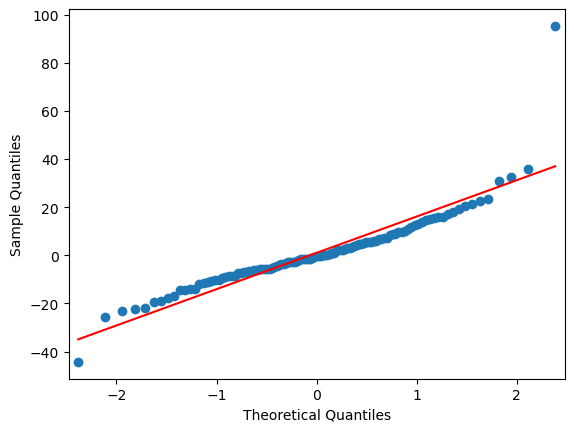

In [205]:
import statsmodels.api as sm
residuals = arima_model.resid
sm.qqplot(residuals, line='s')
plt.show()
# If residuals deviate significantly from normality, more tuning is needed.

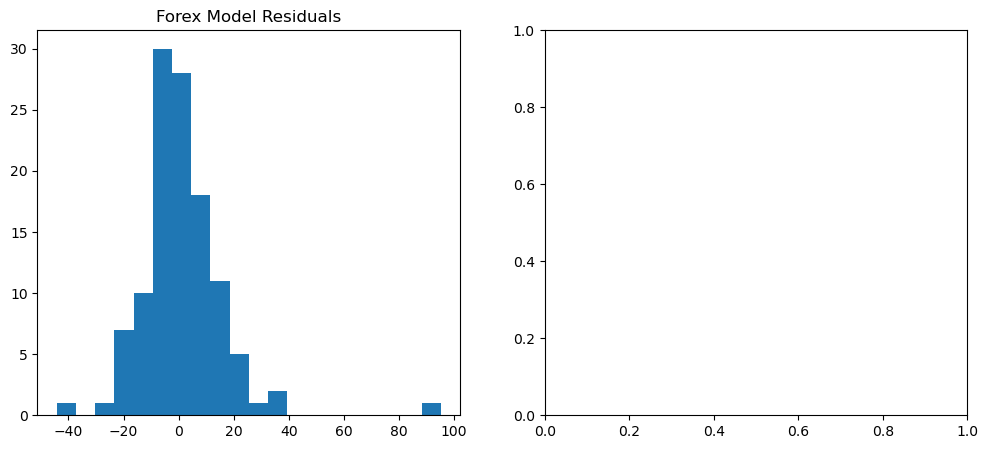

In [200]:
# Residual Analysis
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(arima_model.resid, bins=20)
plt.title("Forex Model Residuals")
plt.subplot(1,2,2)
plt.show()